In [82]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn
from torch import optim
from torchvision import transforms

from tqdm import tqdm
from PIL import Image
import librosa
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt

%matplotlib inline 


In [83]:
FILE_PATH = "/mnt/c/Users/86181/Datasets/Bird"
BIRD_LABEL = {
    "0009": "灰雁",
    "0017": "大天鹅",
    "0034": "绿头鸭",
    "0036": "绿翅鸭",
    "0074": "灰山鹑",
    "0077": "西鹌鹑",
    "0114": "雉鸡",
    "0121": "红喉潜鸟",
    "0180": "苍鹭",
    "0202": "普通鸬鹚",
    "0235": "苍鹰",
    "0257": "欧亚鵟",
    "0265": "西方秧鸡",
    "0281": "骨顶鸡",
    "0298": "黑翅长脚鹬",
    "0300": "凤头麦鸡",
    "0364": "白腰草鹬",
    "0368": "红脚鹬",
    "0370": "林鹬",
    "1331": "麻雀"
}
TRAIN_RATIO = 0.8
VALIDATE_RATIO = 0.2

warnings.filterwarnings('ignore')
torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
# super parameters
batch_size = 100
lr = 0.0005
epoch = 30
max_count = 200
full_data = False

In [85]:
def convert_to_spectrogram(wav_file):
    y, sr = librosa.load(wav_file,sr=None)
    # spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = - librosa.power_to_db(spectrogram, ref=np.max) # use positive value!
    S_dB = Image.fromarray(S_dB)
    return S_dB

In [86]:
def load_files():
    label = []
    wav_data = []
    # eye = np.eye(20)

    # get filenames
    for index, dir in enumerate(BIRD_LABEL.keys()):
        wav_files = os.listdir(FILE_PATH + '/' + dir)

        if(full_data == False):
            wav_files = wav_files[0:max_count]

        print("checking {}".format(dir))
        for wav_file in tqdm(wav_files):
            filename = FILE_PATH + '/' + dir + '/' + wav_file
            wav = convert_to_spectrogram(filename)
            wav_data.append(wav)
            label.append(index)

    print('done')

    # shuffle
    state = np.random.get_state()
    np.random.shuffle(wav_data)
    np.random.set_state(state)
    np.random.shuffle(label)

    # divide
    length = len(label)
    train_index = int(length*TRAIN_RATIO)

    train_data = wav_data[0:train_index]
    train_label = label[0:train_index]
    validate_data = wav_data[train_index:]
    validate_label = label[train_index:]

    return train_data,train_label,validate_data,validate_label


In [87]:
class SoundDataSet(Dataset):
    def __init__(self,data_list,label_list,transform):
        self.transform = transform
        self.wav_data = data_list
        self.label = label_list

    def __getitem__(self, index):
        wav = self.wav_data[index]
        wav = self.transform(wav)
        label = self.label[index]
        return wav, label

    def __len__(self):
        return len(self.wav_data)

In [88]:
def get_loader():
    
    train_data,train_label,validate_data,validate_label = load_files()

    transform = transforms.Compose([
        transforms.Resize((50,50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5,std=0.5)
    ])

    # build dataset
    train_dataset = SoundDataSet(train_data,train_label,transform)
    validate_dataset = SoundDataSet(validate_data,validate_label,transform)

    # build dataloader
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=1)

    validate_loader = DataLoader(dataset=validate_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1)

    return train_loader,validate_loader




In [89]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.batchNorm1 = nn.BatchNorm2d(32)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.batchNorm3 = nn.BatchNorm2d(256)
        self.relu = nn.LeakyReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=32)
        self.linear2 = nn.Linear(in_features=32, out_features=20)

    def forward(self,x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        # x = self.batchNorm3(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout1(x)

        x = self.conv4(x)
        # x = self.batchNorm4(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout1(x)

        x = x.view(x.shape[0], -1) # 将数据设置为1维
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

In [90]:
def get_network():
    cnn = CNN()
    optimizer = optim.Adam(cnn.parameters(),
                           lr = lr,
                           betas = (0.9, 0.999),
                           eps = 1e-8,
                           weight_decay = 0)
    loss = nn.CrossEntropyLoss()
    cnn = cnn.to(device = device)
    return cnn, optimizer, loss

In [91]:
# load data
x = np.arange(1, epoch + 1, 1)
train_loader, validate_loader = get_loader()
cnn, optimizer, loss = get_network()

checking 0009


 12%|█▏        | 23/200 [00:02<00:12, 14.06it/s]

In [ ]:
# train and validate

train_l_sum, train_acc_sum = 0.0, 0.0
validate_l_sum, validate_acc_sum = 0.0, 0.0
train_loss = []
train_acc = []
validate_loss = []
validate_acc = []

# train and validate
for i in range(epoch):
    n = 0
    print("epoch {}:".format(i))
    # train
    for X, Y in tqdm(train_loader):
        X, Y = X.to(device), Y.to(device)
        Y_hat = cnn(X)
        l = loss(Y_hat, Y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l_sum += l.item()
        train_acc_sum += (Y_hat.argmax(dim=1) == Y).sum().item()
        n += Y.shape[0]
    print("train: loss %.5f, train accuracy %.1f%%" %(train_l_sum / n, 100 * train_acc_sum / n))
    train_loss.append(train_l_sum / n)
    train_acc.append(100 * train_acc_sum / n)

    train_l_sum = 0.0
    train_acc_sum = 0.0

    # validate
    n = 0
    with torch.no_grad():  # 关闭梯度记录
        for X, Y in tqdm(validate_loader):
            X, Y = X.to(device), Y.to(device)
            Y_hat = cnn(X)
            l = loss(Y_hat, Y)
            validate_l_sum += l.item()
            validate_acc_sum += (Y_hat.argmax(dim=1) == Y).sum().item()
            n += Y.shape[0]
        print("validate: loss %.5f, validate accuracy %.1f%%" %
                (validate_l_sum / n, 100 * validate_acc_sum / n))
    if(len(validate_acc)==0 or 100*validate_acc_sum/n>validate_acc[-1]): # the network is getting better
        torch.save(cnn,'cnn.pkl')
        print("save the network parameters.")
    validate_loss.append(validate_l_sum / n)
    validate_acc.append(100 * validate_acc_sum / n)

    validate_l_sum = 0.0
    validate_acc_sum = 0.0

epoch 0:


100%|██████████| 31/31 [00:08<00:00,  3.58it/s]


train: loss 0.02985, train accuracy 7.3%


100%|██████████| 8/8 [00:01<00:00,  7.32it/s]


validate: loss 0.03021, validate accuracy 11.4%
save the network parameters.
epoch 1:


100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


train: loss 0.02839, train accuracy 13.1%


100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


validate: loss 0.02791, validate accuracy 19.1%
save the network parameters.
epoch 2:


100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


train: loss 0.02642, train accuracy 19.6%


100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


validate: loss 0.02590, validate accuracy 25.5%
save the network parameters.
epoch 3:


100%|██████████| 31/31 [00:08<00:00,  3.59it/s]


train: loss 0.02366, train accuracy 28.1%


100%|██████████| 8/8 [00:01<00:00,  6.89it/s]


validate: loss 0.02332, validate accuracy 30.8%
save the network parameters.
epoch 4:


100%|██████████| 31/31 [00:08<00:00,  3.45it/s]


train: loss 0.02181, train accuracy 34.1%


100%|██████████| 8/8 [00:01<00:00,  7.82it/s]


validate: loss 0.02177, validate accuracy 36.7%
save the network parameters.
epoch 5:


100%|██████████| 31/31 [00:09<00:00,  3.34it/s]


train: loss 0.02041, train accuracy 36.6%


100%|██████████| 8/8 [00:01<00:00,  7.68it/s]


validate: loss 0.02131, validate accuracy 38.1%
save the network parameters.
epoch 6:


100%|██████████| 31/31 [00:08<00:00,  3.74it/s]


train: loss 0.01848, train accuracy 42.4%


100%|██████████| 8/8 [00:01<00:00,  7.62it/s]


validate: loss 0.01909, validate accuracy 43.1%
save the network parameters.
epoch 7:


100%|██████████| 31/31 [00:09<00:00,  3.35it/s]


train: loss 0.01733, train accuracy 46.4%


100%|██████████| 8/8 [00:01<00:00,  6.86it/s]


validate: loss 0.01755, validate accuracy 49.3%
save the network parameters.
epoch 8:


100%|██████████| 31/31 [00:08<00:00,  3.59it/s]


train: loss 0.01591, train accuracy 51.5%


100%|██████████| 8/8 [00:01<00:00,  7.67it/s]


validate: loss 0.01606, validate accuracy 51.3%
save the network parameters.
epoch 9:


100%|██████████| 31/31 [00:08<00:00,  3.55it/s]


train: loss 0.01445, train accuracy 55.5%


100%|██████████| 8/8 [00:00<00:00,  8.20it/s]


validate: loss 0.01594, validate accuracy 53.8%
save the network parameters.
epoch 10:


100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


train: loss 0.01366, train accuracy 57.1%


100%|██████████| 8/8 [00:01<00:00,  7.33it/s]


validate: loss 0.01454, validate accuracy 57.4%
save the network parameters.
epoch 11:


100%|██████████| 31/31 [00:07<00:00,  3.88it/s]


train: loss 0.01262, train accuracy 61.4%


100%|██████████| 8/8 [00:01<00:00,  7.99it/s]


validate: loss 0.01465, validate accuracy 56.1%
epoch 12:


100%|██████████| 31/31 [00:08<00:00,  3.68it/s]


train: loss 0.01199, train accuracy 63.6%


100%|██████████| 8/8 [00:01<00:00,  7.46it/s]


validate: loss 0.01281, validate accuracy 62.8%
save the network parameters.
epoch 13:


100%|██████████| 31/31 [00:09<00:00,  3.19it/s]


train: loss 0.01102, train accuracy 66.0%


100%|██████████| 8/8 [00:01<00:00,  7.59it/s]


validate: loss 0.01232, validate accuracy 64.6%
save the network parameters.
epoch 14:


100%|██████████| 31/31 [00:08<00:00,  3.64it/s]


train: loss 0.01046, train accuracy 67.9%


100%|██████████| 8/8 [00:01<00:00,  7.62it/s]


validate: loss 0.01270, validate accuracy 63.4%
epoch 15:


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


train: loss 0.01013, train accuracy 69.0%


100%|██████████| 8/8 [00:01<00:00,  7.77it/s]


validate: loss 0.01172, validate accuracy 66.4%
save the network parameters.
epoch 16:


100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


train: loss 0.00959, train accuracy 70.8%


100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


validate: loss 0.01211, validate accuracy 65.4%
epoch 17:


100%|██████████| 31/31 [00:08<00:00,  3.74it/s]


train: loss 0.00946, train accuracy 70.9%


100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


validate: loss 0.01156, validate accuracy 66.6%
save the network parameters.
epoch 18:


100%|██████████| 31/31 [00:07<00:00,  3.89it/s]


train: loss 0.00835, train accuracy 74.1%


100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


validate: loss 0.01134, validate accuracy 68.0%
save the network parameters.
epoch 19:


100%|██████████| 31/31 [00:08<00:00,  3.61it/s]


train: loss 0.00823, train accuracy 73.4%


100%|██████████| 8/8 [00:01<00:00,  7.16it/s]


validate: loss 0.01096, validate accuracy 70.1%
save the network parameters.
epoch 20:


100%|██████████| 31/31 [00:08<00:00,  3.69it/s]


train: loss 0.00786, train accuracy 75.8%


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


validate: loss 0.01022, validate accuracy 69.8%
epoch 21:


100%|██████████| 31/31 [00:08<00:00,  3.46it/s]


train: loss 0.00750, train accuracy 76.6%


100%|██████████| 8/8 [00:01<00:00,  6.65it/s]


validate: loss 0.01077, validate accuracy 68.1%
epoch 22:


100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


train: loss 0.00721, train accuracy 78.5%


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


validate: loss 0.01015, validate accuracy 68.8%
save the network parameters.
epoch 23:


100%|██████████| 31/31 [00:07<00:00,  3.90it/s]


train: loss 0.00668, train accuracy 79.4%


100%|██████████| 8/8 [00:01<00:00,  7.06it/s]


validate: loss 0.01019, validate accuracy 70.4%
save the network parameters.
epoch 24:


100%|██████████| 31/31 [00:07<00:00,  3.89it/s]


train: loss 0.00660, train accuracy 79.7%


100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


validate: loss 0.00995, validate accuracy 72.2%
save the network parameters.
epoch 25:


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


train: loss 0.00616, train accuracy 80.3%


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


validate: loss 0.00971, validate accuracy 71.3%
epoch 26:


100%|██████████| 31/31 [00:07<00:00,  3.92it/s]


train: loss 0.00573, train accuracy 81.8%


100%|██████████| 8/8 [00:01<00:00,  7.92it/s]


validate: loss 0.00921, validate accuracy 76.0%
save the network parameters.
epoch 27:


100%|██████████| 31/31 [00:07<00:00,  3.92it/s]


train: loss 0.00561, train accuracy 81.6%


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


validate: loss 0.00975, validate accuracy 73.1%
epoch 28:


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


train: loss 0.00591, train accuracy 81.9%


100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


validate: loss 0.00886, validate accuracy 74.9%
save the network parameters.
epoch 29:


100%|██████████| 31/31 [00:07<00:00,  3.88it/s]


train: loss 0.00514, train accuracy 83.6%


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

validate: loss 0.00927, validate accuracy 73.2%


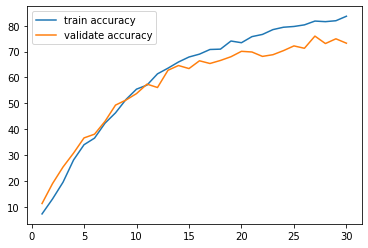

In [ ]:
plt.figure(1)
plt.plot(x, train_acc, label='train accuracy')
plt.plot(x, validate_acc, label='validate accuracy')
plt.legend()
plt.show()

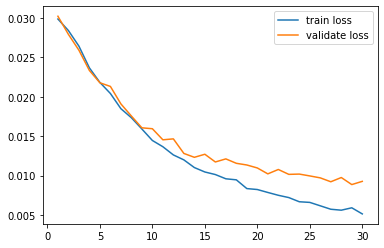

In [ ]:
plt.figure(2)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, validate_loss, label='validate loss')
plt.legend()
plt.show()